# Practical 2 - Mapping with cartopy

In the first practical for EGM711, you learned how to use ArcGIS Pro to make maps, given shapefiles of different features of interest in Northern Ireland. In this practical, you will repeat the exercise, this time using `cartopy`, `geopandas`, and `matplotlib`, three python packages used for making maps, working with vector data, and making plots, respectively. 

## Objectives
- become familiar with geopandas, cartopy, and matplotlib, including reading the provided documentation
- use list comprehensions to simplify some for loops

## 1. Getting started
First, run the cell below. It will load the python modules we'll be using in todthe practical, as well as define a few helper functions that we'll use later on. For now, don't worry too much about what each individual line does - we'll go over these in a bit more depth as we go. Remember also that if you get stuck, you can get help in a few ways:

1. the built-in help (i.e., `help(plt.text)`)
2. using ipython's (the python interpreter used by jupyter-notebooks) help shortcut (i.e., `plt.text?`)
3. finding the online documentation for the module (usually achieved via option 4)
4. searching google (or your search engine of choice) 
5. consulting your favorite medicine man/shaman/spiritual guide
6. asking the instructor, who will in all likelihood resort to one of the other options (usually 5 or 4).

In [2]:
# this lets us use the figures interactively
%matplotlib notebook

import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

plt.ion() # make the plotting interactive

# generate matplotlib handles to create a legend of the features we put in our map.
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles

# create a scale bar of length 20 km in the upper right corner of the map
# adapted this question: https://stackoverflow.com/q/32333870
# answered by SO user Siyh: https://stackoverflow.com/a/35705477
def scale_bar(ax, location=(0.92, 0.95)):
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]

    tmc = ccrs.TransverseMercator(sbllx, sblly)
    x0, x1, y0, y1 = ax.get_extent(tmc)
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    plt.plot([sbx, sbx - 20000], [sby, sby], color='k', linewidth=9, transform=tmc)
    plt.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=6, transform=tmc)
    plt.plot([sbx-10000, sbx - 20000], [sby, sby], color='w', linewidth=6, transform=tmc)

    plt.text(sbx, sby-4500, '20 km', transform=tmc, fontsize=8)
    plt.text(sbx-12500, sby-4500, '10 km', transform=tmc, fontsize=8)
    plt.text(sbx-24500, sby-4500, '0 km', transform=tmc, fontsize=8)

# load the outline of Northern Ireland for a backdrop
outline = gpd.read_file('data_files/NI_outline.shp')


## 2. Loading the data
Great. Now that we've imported most of the modules we'll be needing, and defined a few helper functions, we can actually load our data. To load the shapefile data, we will use [GeoPandas](http://geopandas.org/), an open-source package designed to make working with geospatial data in python easier. GeoPandas is built off of Pandas, a powerful data analysis tool. We will be working with both of these packages more in the weeks to come.

In [3]:
towns = gpd.read_file('data_files/Towns.shp')
water = gpd.read_file('data_files/Water.shp')
rivers = gpd.read_file('data_files/Rivers.shp')
counties = gpd.read_file('data_files/Counties.shp')

GeoPandas loads the data associated with a shapefile into a GeoDataFrame, a tabular data structure that always has a column describing a feature's geometry. Each line in the table corresponds to a feature in the shapefile, just like the attribute table you are familiar with from ArcGIS/QGIS. 

We'll work with GeoDataFrames more in next week's practical, but for now see if you can figure out the total area of lakes in the `Water` dataset that are smaller than 10 square kilometers. I'll provide two hints to get you started:

1. GeoDataFrames can be subset using a conditional and a column in the GeoDataFrame. For example, to select all water bodies with a surface area above 1 square kilometer, you might type something like `water[water['Area_km2'] > 1]`. Note that this would return a GeoDataFrame, that you could select columns from.
2. The numerical columns of a GeoDataFrame (also called GeoSeries) have built-in operators such as __max__, __min__, __mean__, and so on. To get the mean area of _all_ of the features in the `Water` dataset, you could type something like `water['Area_km2'].mean()`

That should be enough to get you started - if you get stuck, be sure to ask for help.

In [4]:
water # run this to see what the geodataframe looks like.
# below, write a command (or series of commands) to calculate the total area of lakes < 10 km2 in the water dataset.
water[water['Area_km2'] < 10]['Area_km2'].sum()
# first, write a command that selects lakes with an area smaller than 10 km2 from the 

29.085160000000002

## 3. Creating maps with matplotlib and cartopy

Now that we're more familiar with the dataset, we can start building our map. For this portion of the practical, we'll be mostly using [matplotlib](https://matplotlib.org/), a python package designed for making plots and graphs, and [cartopy](https://scitools.org.uk/cartopy/docs/latest/), a package designed for making maps and representing geopatial data. 

<IPython.core.display.Javascript object>


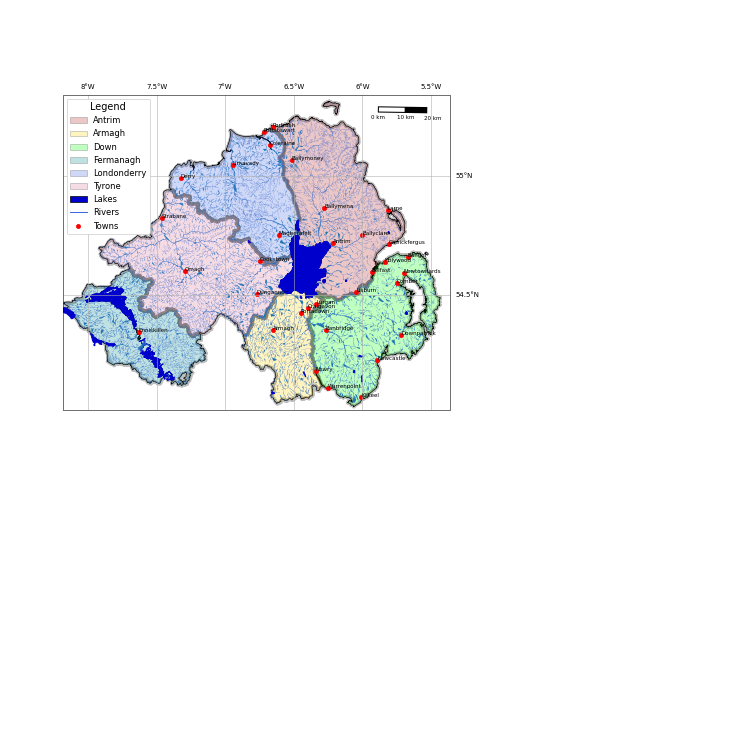

In [5]:
myFig = plt.figure(figsize=(10, 10))  # create a figure of size 10x10 (representing the page size in inches)

myCRS = ccrs.UTM(29)  # create a Universal Transverse Mercator reference system to transform our data.
# be sure to fill in XX above with the correct number for the area we're working in.

ax = plt.axes(projection=ccrs.Mercator())  # finally, create an axes object in the figure, using a Mercator
# projection, where we can actually plot our data.

### Adding data to the map

Now that we've created a figure and axes, we can start adding data to the map. To start, we'll add the municipal borders. 

In order to add these to the map, we first have to create features that we can add to the axes using the `ShapelyFeature` class from `cartopy.feature`. The initialization method for this class takes a minimum of two arguments, an __iterable__ containing the geometries that we're using, and a CRS representation. To add the County borders, then, we would use `counties['geometry']`, the GeoSeries of the feature geometries in our Municipalities shapefile, and `myCRS`, the CRS object representing the UTM Zone for Northern Ireland.

The other arguments that we pass to `ShapelyFeature` tell `matplotlib` how to draw the features - in this case, with an edge color of black and a face color of gray. Once we've created the features, we add them to the axes using the `add_feature` method.

We'll also want to zoom the map into our area of interest using the boundary of the shapefile features (using `ax.set_extent`), and finally re-display the figure below so we don't have to scroll up and down all the time.

In [6]:
# first, we just add the outline of Northern Ireland using cartopy's ShapelyFeature
outline_feature = ShapelyFeature(outline['geometry'], myCRS, edgecolor='k', facecolor='w')
xmin, ymin, xmax, ymax = outline.total_bounds
ax.add_feature(outline_feature) # add the features we've created to the map.

# using the boundary of the shapefile features, zoom the map to our area of interest
ax.set_extent([xmin, xmax, ymin, ymax], crs=myCRS) # because total_bounds gives output as xmin, ymin, xmax, ymax,
# but set_extent takes xmin, xmax, ymin, ymax, we re-order the coordinates here.

# myFig # re-display the figure here.

This is fine, but a bit boring. For one thing, we might want to set different colors for the different municipalities, rather than having them all be the same color. To do this, we'll first have to count the number of unique municipalities in our dataset, then select colors to represent each of them. 


<span style="color:blue;font-weight:bold;font-size:14pt">Question: Why might we do this, rather than just use the number of features in the dataset?</span>


Run the cell below to count the number of unique municipalities in the dataset, using the `unique` method on the __CountyName__ GeoSeries. Note that in addition to the standard indexing (i.e., `counties['CountyName']`), we are accessing __CountyName__ directly as an attribute of `counties` (i.e., `counties.CountyName`). Provided that the column name follows particular rules ([more on this here](http://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access)), there is no difference between these two methods - they give the same results.

In [7]:
# get the number of unique municipalities we have in the dataset
num_counties = len(counties.CountyName.unique())
print('Number of unique features: {}'.format(num_counties)) # note how we're using {} and format here!

Number of unique features: 6


Now that you've found the number of colors you need to choose, you can use the image below to make a list of the colors. There are other ways to select colors using matplotlib, including using RGB values, but that's for another day. If you're interested in learning more, you can check out the documentation [here](https://matplotlib.org/stable/api/colors_api.html).

![title](imgs/named_colors.png)
[source](https://matplotlib.org/stable/gallery/color/named_colors.html)

In [8]:
# pick colors for the individual county boundaries - make sure to add enough for each of the counties
# to add a color, enclose the name above (e.g., violet) with single (or double) quotes: 'violet'
# remember that each colors should be separated by a comma
county_colors = ['firebrick','gold','lime','darkcyan','royalblue','palevioletred']

# get a list of unique names for the county boundaries
county_names = list(counties.CountyName.unique())
county_names.sort() # sort the counties alphabetically by name

# next, add the municipal outlines to the map using the colors that we've picked.
# here, we're iterating over the unique values in the 'CountyName' field.
# we're also setting the edge color to be black, with a line width of 0.5 pt. 
# Feel free to experiment with different colors and line widths.
for i, name in enumerate(county_names):
    feat = ShapelyFeature(counties['geometry'][counties['CountyName'] == name], myCRS, 
                          edgecolor='k',
                          facecolor=county_colors[i],
                          linewidth=5,
                          alpha=0.25)
    ax.add_feature(feat)

# myFig # to show the updated figure

Now that we've done this for the municipal boundaries, we can also do this for the water and river datasets.

In [9]:
# here, we're setting the edge color to be the same as the face color. Feel free to change this around,
# and experiment with different line widths.
water_feat = ShapelyFeature(water['geometry'], myCRS, 
                            edgecolor='mediumblue', 
                            facecolor='mediumblue',
                            linewidth=1)
ax.add_feature(water_feat)

river_feat = ShapelyFeature(rivers['geometry'], myCRS,
                            edgecolor='royalblue',
                            linewidth=0.2)

ax.add_feature(river_feat)

# ShapelyFeature creates a polygon, so for point data we can just use ax.plot()
town_handle = ax.plot(towns.geometry.x, towns.geometry.y, 'o', color='red', ms=6, transform=myCRS)

# myFig # to show the updated figure

### Adding labels and legends

Now that we have different colors for each of the county boundaries and we've displayed lakes, rivers, and towns, it might be good to have a legend to keep everything straight.

To do this, we get handles for each of the county boundaries, using the colors we defined earlier. Here, we're using our helper function `generate_handles`, which returns a list of `matplotlib` handles, given a list of labels and colors. We then do the same for the water bodies and rivers.

Note that the names in our county dataset are all uppercase - that's not necessarily how we want to display them on the map. To change this, we can use a string method called __title()__, which will capitalize the first letter of each word in a string. We also have to do this for each of the items in our list of names. We _could_ write this as a __for__ loop, like this:

```
nice_names = []  # initalize an empty list
for name in county_names:
    nice_names.append(name.title())

```

But, python offers another, cleaner option, called a [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions). A list comprehension allows us to generate a new list from an existing iterable. To write the same __for__ loop above as a list comprehension takes one line:

```
nice_names = [name.title() for name in county_names]
```

That's it. This creates a new list by iterating over each of the items in county_names, applying a method, __str.title()__, to each item. We'll work more with list comprehensions throughout the module, as they provide a way to simplify some pretty complicated loops.

We can pass each of our lists of handles and labels to `plt.legend`, to generate a legend for the municipal boundaries data. Feel free to experiment with the placement (by changing __loc__ and/or __bbox_to_anchor__), or the font size, the title font size, and so on.

In [10]:
# generate a list of handles for the county datasets
county_handles = generate_handles(counties.CountyName.unique(), county_colors, alpha=0.25)

# note: if you change the color you use to display lakes, you'll want to change it here, too
water_handle = generate_handles(['Lakes'], ['mediumblue'])

# note: if you change the color you use to display rivers, you'll want to change it here, too
river_handle = [mlines.Line2D([], [], color='royalblue')]

# update county_names to take it out of uppercase text
nice_names = [name.title() for name in county_names]

# ax.legend() takes a list of handles and a list of labels corresponding to the objects you want to add to the legend
handles = county_handles + water_handle + river_handle + town_handle
labels = nice_names + ['Lakes', 'Rivers', 'Towns']

leg = ax.legend(handles, labels, title='Legend', title_fontsize=14, 
                 fontsize=12, loc='upper left', frameon=True, framealpha=1)

# myFig # to show the updated figure

Now that we have a legend, let's go ahead and add grid lines to our plot. I've chosen some default gridlines, but you can feel free to change this. What happens if you delete the first and/or last value from xlocs and ylocs? Can you change the labels to show only on the bottom and left side of the map?

<IPython.core.display.Javascript object>


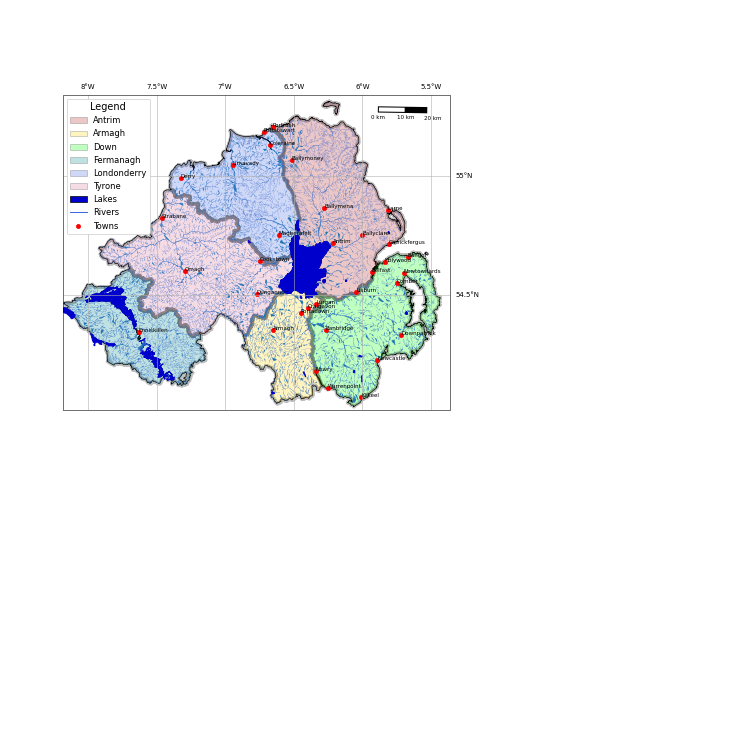

In [11]:
gridlines = ax.gridlines(draw_labels=True,
                         xlocs=[-8, -7.5, -7, -6.5, -6, -5.5], 
                         ylocs=[54, 54.5, 55, 55.5])
gridlines.left_labels = False # turn off the left-side labels
gridlines.bottom_labels = False # turn off the bottom labels
ax.set_extent([xmin, xmax, ymin, ymax], crs=myCRS) # set the extent to the boundaries of the NI outline
myFig # to show the updated figure

Excellent. Now, let's add text labels for each of our individual towns. For each of the points representing our towns/cities, we can place a text label. Look over the cell below, and make sure you understand what each line is doing. If you're not sure you understand, you can post your questions on Blackboard.

In [12]:
for i, row in towns.iterrows():
    x, y = row.geometry.x, row.geometry.y # get the x,y location for each town
    plt.text(x, y, row['TOWN_NAME'].title(), fontsize=8, transform=myCRS) # use plt.text to place a label at x,y

Last but not least, let's add a scale bar to the plot. The scale_bar function we've defined above will produce a scale bar with divisions at 10 and 20 km, with a location in the upper right corner as default. Try to experiment with this a bit - can you design a scale bar with divisions at 1, 5, and 10 km? It's not as straightforward as it is in ArcGIS, but it might provide an interesting challenge if you're interested in developing your programming skills a bit.

In [13]:
scale_bar(ax)

C:\Users\pjbog\AppData\Local\Temp\ipykernel_13200\3072797225.py:29: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)


Finally, we'll save our figure. The command written below will save the figure to the current folder, in a file called `map.png`, with no border around the outside of the map, and with a resolution of 300 dots per inch. As always, feel free to change these parameters.

In [ ]:
myFig.savefig('mymap.png', bbox_inches='tight', dpi=300)

## Next steps

In this directory, you should also have a python script, __practical2_script.py__, which will create the same map that we've made here (though perhaps with different colors).

Note that the __towns__ dataset has an attribute, __STATUS__, that describes whether the feature represents a __Town__ (e.g., Coleraine), or a __City__ (e.g., Belfast). As a further exercise, see if you can modify the script to plot all of the __Towns__ with one marker (e.g., the gray square used above), and plot all of the __Cities__ plot with a different marker, then add these to the legend. For more information on the available markers and colors for matplotlib, see the [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html).